# TP1 : Extreme value theory

# Rain data in south England
1- Make the same Exploratory Data Analysis as in the previous questions to check if the data has seasonality, and can be modeled by a gaussain

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import seaborn as sns
from scipy import stats
from pyextremes import plot_mean_residual_life, plot_parameter_stability
from scipy.stats import genextreme


df_rain = pd.read_csv("rain.csv")
df_rain

,x
0,0.0
1,2.3
2,1.3
3,6.9
4,4.6
...,...
17526,1.3
17527,0.0
17528,1.8
17529,3.8


Length of rain: 17531


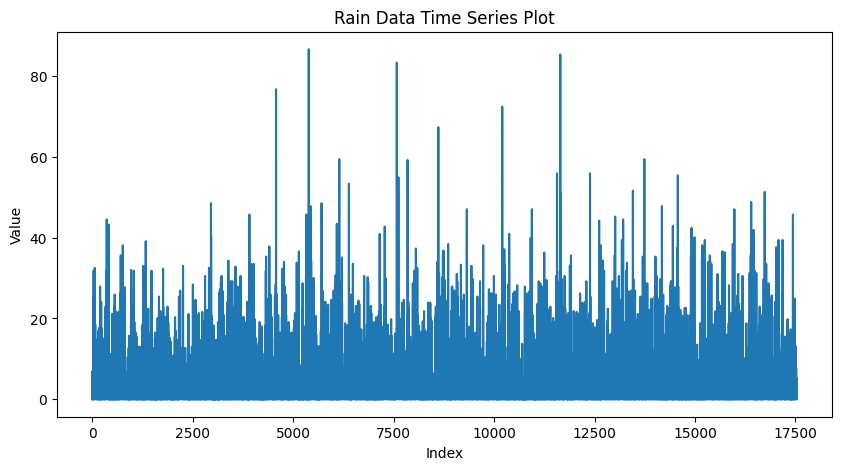

ADF Statistic: -30.580304384101527
p-value: 0.0
Critical Values: {'1%': -3.4307233450435692, '5%': -2.8617050041000534, '10%': -2.5668578273974973}
The series is stationary (reject the null hypothesis).


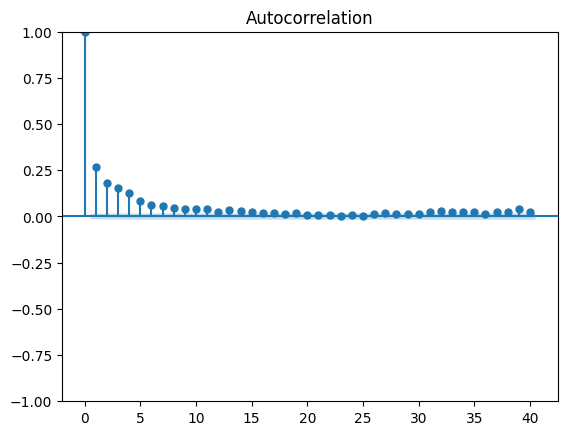

Ljung-Box Test Results:
         lb_stat  lb_pvalue
25  2954.579369        0.0


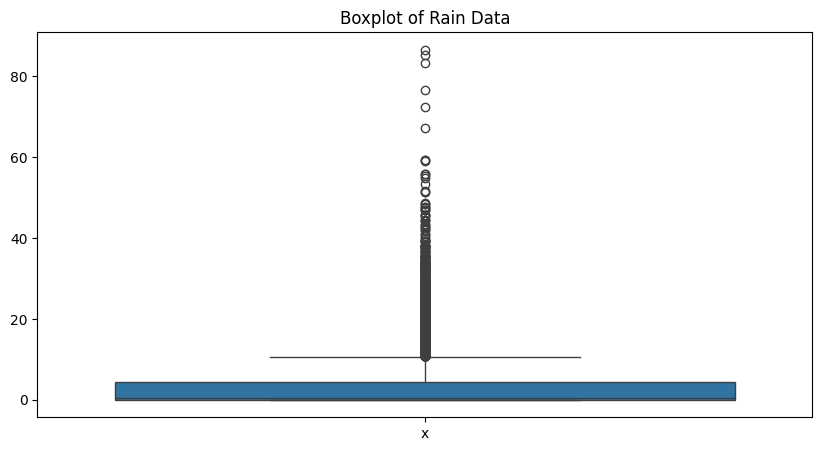

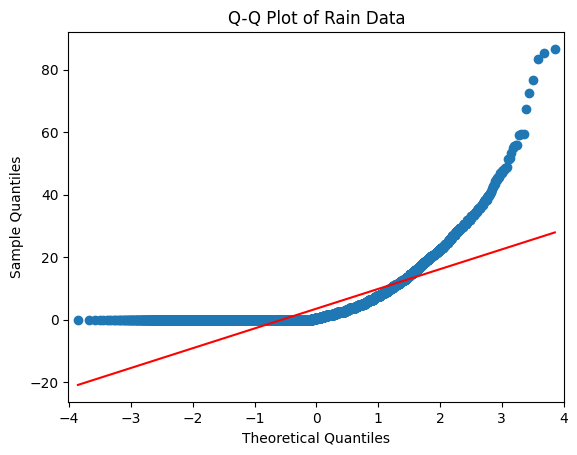

Shapiro-Wilk Test Statistic: 0.6069575121864537
p-value: 2.3998383881730107e-106
The data is not normally distributed (reject the null hypothesis).


In [4]:
print("Length of rain:", len(df_rain))

# Time series plot
plt.figure(figsize=(10, 5))
plt.plot(df_rain)
plt.title('Rain Data Time Series Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

# ADF test
adf_test = ts.adfuller(df_rain)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

# Low p-value means unit-root hypothesis rejected, series is stationary
if adf_test[1] < 0.05:
    print("The series is stationary (reject the null hypothesis).")
else:
    print("The series is not stationary (fail to reject the null hypothesis).")


# 4. ACF Plot (Autocorrelation Function)
sm.graphics.tsa.plot_acf(df_rain, lags=40)
plt.show()


# 6. Ljung-Box test for stationarity
ljung_box_test = sm.stats.acorr_ljungbox(df_rain, lags=[25], return_df=True)
print("Ljung-Box Test Results:\n", ljung_box_test)

# 7. Check if the data is Gaussian

# Boxplot of 'danish'
plt.figure(figsize=(10, 5))
sns.boxplot(df_rain)
plt.title("Boxplot of Rain Data")
plt.show()

# Q-Q Plot
sm.qqplot(df_rain.sort_values(by='x'), line='s')
plt.title("Q-Q Plot of Rain Data")
plt.show()

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(df_rain)
print("Shapiro-Wilk Test Statistic:", shapiro_test[0])
print("p-value:", shapiro_test[1])

# Interpretation of Shapiro-Wilk test
if shapiro_test[1] < 0.05:
    print("The data is not normally distributed (reject the null hypothesis).")
else:
    print("The data is normally distributed (fail to reject the null hypothesis).")

2- Propose two methods to estimate the 100 year return level based on *peaks over threshold*.

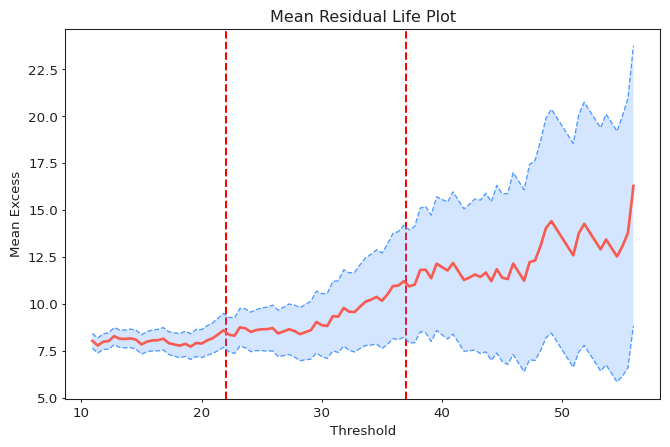

In [13]:
plot_mean_residual_life(df_rain.iloc[:, 0])
plt.title("Mean Residual Life Plot")
plt.xlabel("Threshold")
plt.ylabel("Mean Excess")
plt.axvline(22, linestyle="--", color="red")
plt.axvline(37, linestyle="--", color="red")
plt.show()

The linear MRL space is around the interval $[22, 37]$. The threshold we need to choose in the POT method is in this interval.

In [52]:
u = 25
data = df_rain.iloc[:, 0].to_numpy()
data_thresh = data[data > u] - u
xi_fit, mu_fit, sigma_fit = stats.genpareto.fit(data_thresh)


proba_above_thresh = len(data_thresh) / len(data)

# We compute the estimated quantile
alpha_100 = 1 / (100 * 365)
u_100 = u + sigma_fit / xi_fit * ((alpha_100 / proba_above_thresh) ** (-xi_fit) - 1)
print(f"GDP 100 years return level: {u_100}")

GDP 100 years return level: 97.32124082949512


2- Propose two methods to estimate the 100 year return level based on *block maxima*

In [53]:
# Take full years in rain dataset
data = df_rain.iloc[: len(df_rain) // 365 * 365]

# Reshape the data as blocks of 365 days of data
data = data.to_numpy().reshape((365, len(data) // 365))

In [58]:
# We fit a GEV distribution onto the block maxima
block_maxima = data.max(axis=0)
c_fit, mu_fit, scale_fit = genextreme.fit(block_maxima)

xi_fit = -c_fit

We want to test the GEV hypothesis, and see how well the fit actually is. 

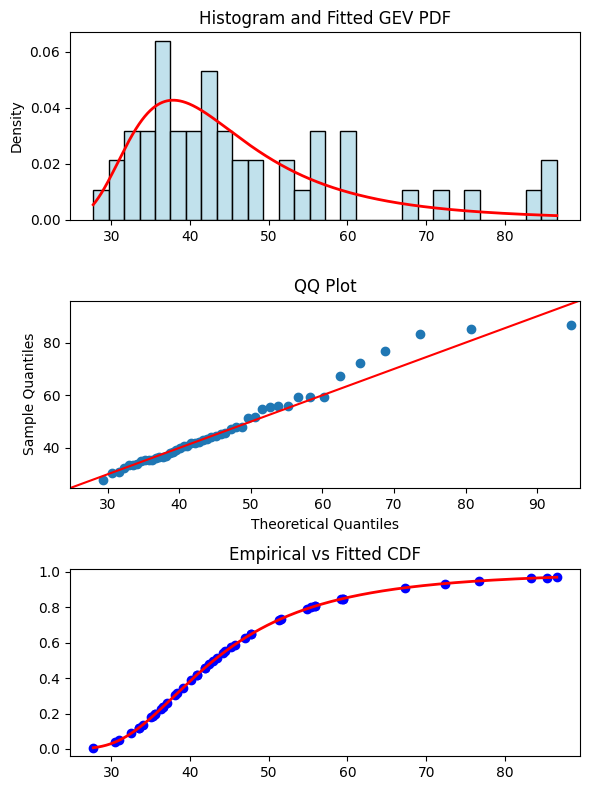

In [55]:
fig, axes = plt.subplots(3, figsize=(6, 8))

# Histogram and GEV PDF
ax1 = axes[0]
sns.histplot(
    block_maxima, bins=30, kde=False, stat="density", ax=ax1, color="lightblue"
)
x = np.linspace(min(block_maxima), max(block_maxima), 1000)
gev_pdf = genextreme.pdf(x, c_fit, loc=mu_fit, scale=scale_fit)
ax1.plot(x, gev_pdf, "r-", lw=2, label="GEV PDF")
ax1.set_title("Histogram and Fitted GEV PDF")

# QQ Plot
ax2 = axes[1]
sm.qqplot(
    np.sort(block_maxima),
    dist=genextreme(c_fit, loc=mu_fit, scale=scale_fit),
    line="45",
    ax=ax2,
)
ax2.set_title("QQ Plot")

# Probability plot (CDF)
ax3 = axes[2]
gev_cdf = genextreme.cdf(np.sort(block_maxima), c_fit, loc=mu_fit, scale=scale_fit)
ax3.plot(np.sort(block_maxima), gev_cdf, "bo", label="Empirical")
ax3.plot(
    x,
    genextreme.cdf(x, c_fit, loc=mu_fit, scale=scale_fit),
    "r-",
    lw=2,
    label="GEV CDF",
)
ax3.set_title("Empirical vs Fitted CDF")

plt.tight_layout()
plt.show()

Globally, the empirical and theoretical quantiles match for the major part, yet the more extreme quantiles are unprecise. This is likely due to the extreme values in density that modify the behaviour of the empirical density.

We compute the quantiles of the GEV distribution, with $T$ in years:
$$1 - \frac{1}{T} = \exp\left(-\left(1+\frac{u_{100}-\mu}{\sigma}\right)^{\frac{-1}{\xi}}\right) \iff u_{100} = \frac{\sigma}{\xi}\left(\log\left(\frac{T}{T - 1}\right)^{-\xi}-1\right) + \mu$$

In [56]:
u_100_gev = sigma_fit / xi_fit * (np.log(100/99) ** (-xi_fit) - 1) + mu_fit
print(f"GEV 100 years return level: {u_100_gev}")

GEV 100 years return level: 100.49358163381194


3- Compare the estimations obtained in both models.

The two models give us similar quantiles value.

We note that $\hat z_{100, GDP} \in [95, 115]$. This is due to the valid set of values for the threshold using the MRL method being between 25 and 37.